<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/neural_similarity_matrices_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this copy of the notebook, I am using **neural similarity** (instead of dissimilarity) and I use a **Fisher transform** on the neural similarity matrix. The goal is to figure out why so many subjects cluster at the bottom near 0. Peter Dayan said there is probably something wrong with the model fitting.

# Introduction

This notebook uses the Julich atlas (threshold at prob>0.75) to segment data from Garvert et al. 2017 eLife.
We define hippocampal ROIs including Dentate Gyrus and Cornu Ammonis (no subiculum for now), and segment them according to y=-21 (as in Poppenk et al. 2013 eLife).
The main thing to change is in the section "Load beta map" (i.e. folder and path specification).

# Parameters

In [1]:
threshold = 50 # Threshold for the probabilistic atlas (there is a tradeoff between reliability and number of voxels
normalizeSR = True # Whether to use a row-normalized SR or not
ub = 100 # Bound for the model coefficients
metric = 'correlation' # Metric to use to measure neural similarity!!

## Install and import packages

In [2]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 108.3 MB/s eta 0:00:00


In [3]:
from nilearn import image
from nilearn import plotting, image, datasets
from nilearn.datasets import load_mni152_template
from nilearn.datasets import fetch_atlas_aal
import nibabel as nib
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import tempfile
import os
from PIL import Image
from copy import copy
from nilearn.image import resample_to_img
import matplotlib.colors as mcolors
from scipy.optimize import minimize
from scipy.special import expit
from scipy.special import logit
from nilearn import plotting, image, datasets, masking
from scipy.stats import ttest_rel
from scipy.linalg import expm

## Functions

## Segmentation
Functions to segment the hippocampus along the x (left and right) and y (posterior and anterior) axes.

In [4]:
def segmentHippocampusX(mask, x_index):
  # This function segments the mask along the x axis, into left and right.
  # Note: mask is a 3D boolean array.
  # In the MNI, the midline corresponds to x=0. However, we need to convert it
  # into voxel coordinates.
  # The output is a dictionary with two keys (left and right).

  right = mask.copy() # I use copy to avoid getting views of variables
  left = mask.copy()

  right[:x_index,:,:] = 0
  # then y_index is set to 0 (and discarded)
  end = mask.shape[0]
  left[x_index:end,:,:] = 0

  return {'left': left,
          'right': right}


In [5]:
def segmentHippocampusY(mask, y_index_anterior, y_index_posterior):
    """
    Segment a hippocampal mask into anterior and posterior portions
    with an optional gap between y_index_posterior and y_index_anterior.

    Parameters
    ----------
    mask : 3D boolean array
        #Full hippocampal mask in MNI space.
    y_index_anterior : int
        #Voxel index corresponding to the *start* of the anterior portion (e.g., y = -18).
    y_index_posterior : int
        #Voxel index corresponding to the *end* of the posterior portion (e.g., y = -24).

    Returns
    -------
    dict
        {'anterior': anterior_mask, 'posterior': posterior_mask}
    """
    anterior_mask = mask.copy()
    posterior_mask = mask.copy()

    end = mask.shape[1]

    # posterior: keep y < y_index_posterior
    posterior_mask[:, y_index_posterior:end, :] = 0

    # anterior: keep y > y_index_anterior
    anterior_mask[:, :y_index_anterior, :] = 0

    return {'posterior': posterior_mask,
            'anterior': anterior_mask}

In [6]:
#def segmentHippocampusY(mask, y_idx_post_end, y_idx_mid_end, y_idx_ant_start):
    #"""
    #Segment a hippocampal mask into posterior, middle, and anterior portions
    #along the y-axis (MNI convention: posterior < anterior).

    #Parameters
    #----------
    #mask : 3D boolean array
        #Full hippocampal mask in MNI space.
    #y_idx_post_end : int
        #Voxel index marking the *end* of the posterior portion (e.g., y = -30).
    #y_idx_mid_end : int
        #Voxel index marking the *end* of the middle portion (e.g., y = -19).
    #y_idx_ant_start : int
        #Voxel index marking the *start* of the anterior portion (e.g., y = -18).

    #Returns
    #-------
    #dict
        #{'posterior': posterior_mask,
         #'middle': middle_mask,
         #'anterior': anterior_mask}
    #"""
    #posterior_mask = np.zeros_like(mask)
    #middle_mask = np.zeros_like(mask)
    #anterior_mask = np.zeros_like(mask)

    # Fill each region based on y-axis voxel indices
    #posterior_mask[:, :y_idx_post_end, :] = mask[:, :y_idx_post_end, :]
    #middle_mask[:, y_idx_post_end:y_idx_mid_end, :] = mask[:, y_idx_post_end:y_idx_mid_end, :]
    #anterior_mask[:, y_idx_mid_end:y_idx_ant_start, :] = mask[:, y_idx_mid_end:y_idx_ant_start, :]

    #return {'posterior': posterior_mask,
            #'middle': middle_mask,
            #'anterior': anterior_mask}

## Loading data

In [7]:
def load_beta_images(run_dir, condition_ids):
    betas = []
    for cond_id in condition_ids:
        pattern = f"_object_{cond_id}_mean_beta.nii.gz" #alternative: _mean_beta_np.nii.gz (or f"_object_{cond_id}_mean_beta.nii.gz" or f"_concat_object_{cond_id}_beta.nii.gz")
        files = [f for f in os.listdir(run_dir) if pattern in f]
        assert len(files) == 1, f"Expected one match for {pattern}"
        img = nib.load(os.path.join(run_dir, files[0]))
        betas.append(img.get_fdata().flatten())  # flatten to 1D voxel vector
    return np.vstack(betas)  # shape (7, n_voxels)

In [8]:
def extractBetas(beta_img, mask_img):
  # This function take a .nii image from beta_img and from mask_imgs
  # it put them in the same reference frame and then use the latter as a boolean
  # mask
  # The function returns a vector with n elements, where n is the number of non-
  # zero elemnts in mask_img

  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)

  beta_data = beta_img.get_fdata()
  mask_data = resampled_mask_img.get_fdata()

  mask_bool = mask_data > 0  # Ensure mask is binary

  masked_betas = beta_data[mask_bool]
  return masked_betas

## Others

In [9]:
def computeSR(T, gamma, normalize=False):
  # This function computes the SR matrix from a transition matrix T
  # and a gamma value.
  # If normalize=True, SR will be row-normalized, making it alike probabilities
  I = np.eye(T.shape[0])
  difference = I - gamma * T
  # Compute the inverse of (I - gamma * T)
  M = np.linalg.inv(difference)
  if normalize:
    M = M / M.sum(axis=1, keepdims=True)
  return M

In [10]:
def computeDK(A, alpha):
  degrees = np.sum(A, axis=1)
  D = np.diag(degrees)
  L = D - A
  K = expm(-alpha * L)
  return K

In [11]:
def corr_triangles(M1, M2):
  # To correlate neural similarity and model similarity, we need to
  # discard the diagonal. We can't just use squareform because SR is not
  # symmetric necessarily
  M1 = M1[~np.eye(M1.shape[0], dtype=bool)]
  M2 = M2[~np.eye(M2.shape[0], dtype=bool)]
  return pearsonr(M1, M2)

# Define ROIs
In this section the main things to decide are:


*   Probability threshold: Julich atlas is probablistic, so to get binary masks (where a voxel is assigned to 1 only if it belongs to the ROI) we need to threshold it. The value is chosen in line with previous studies (Barnavelli et al. 2025 Nat Commun) and it also corresponds to a sort of elbow in voxel reliability (there is a tradeoff between # of selected voxels and reliability)
*   ROI definition. For now, we define the hippocampus as DG + CA



## Load Juelich brain atlas

In [12]:
julich = datasets.fetch_atlas_juelich("prob-1mm")
julich_img = image.load_img(julich.maps)
julich_data = julich_img.get_fdata()
julich_labels = julich.labels

[fetch_atlas_juelich] Added README.md to /root/nilearn_data

[fetch_atlas_juelich] Dataset created in /root/nilearn_data/fsl

[fetch_atlas_juelich] Downloading data from https://www.nitrc.org/frs/download.php/12096/Juelich.tgz ...

[fetch_atlas_juelich]  ...done. (0 seconds, 0 min)

[fetch_atlas_juelich] Extracting data from /root/nilearn_data/fsl/5f0f3de71552237df29d0de14db5f8c8/Juelich.tgz...

[fetch_atlas_juelich] .. done.

In [13]:
CA_idx = julich_labels.index("GM Hippocampus cornu ammonis") - 1
DG_idx = julich_labels.index("GM Hippocampus dentate gyrus") - 1
#S_idx = julich_labels.index("GM Hippocampus subiculum") - 1

In [14]:
CA = (julich_data[..., CA_idx] > threshold)
DG = (julich_data[..., DG_idx] > threshold)
#S = (julich_data[..., S_idx] > threshold)

# This now returns a 3D boolean array
HP = CA | DG

/tmp/ipython-input-2003817921.py:7: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')
/tmp/ipython-input-2003817921.py:7: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')


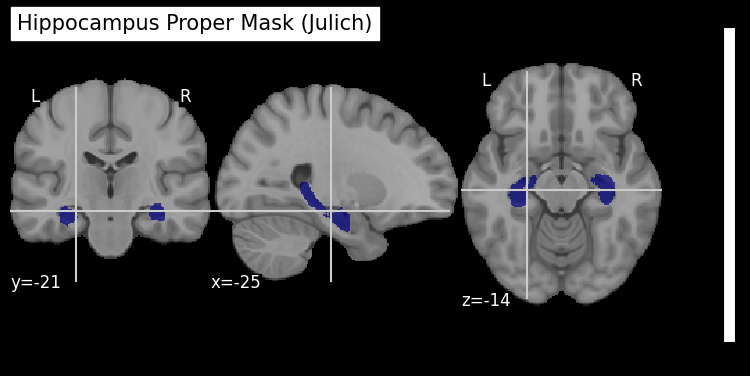

In [15]:
mni_img = datasets.load_mni152_template(resolution=1)

# Step 2: Convert your HP mask to a NIfTI image
hp_mask_img = nib.Nifti1Image(HP.astype(np.uint8), affine=julich_img.affine)

# Step 3: Resample the mask to match the MNI template (if needed)
hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')

# Step 4: Plot the mask over the MNI template
plotting.plot_roi(hp_mask_resampled, bg_img=mni_img, title="Hippocampus Proper Mask (Julich)", cut_coords=[-25,-21, -14])
plotting.show()

## Segment into left and right

In [16]:
mni_x = 0
affine = julich_img.affine
inv_affine = np.linalg.inv(affine) # transform MNI coordinate into matrix indexes
x_index, _, _ = np.round(inv_affine @ np.array([mni_x, 0, 0, 1])).astype(int)[:3]

# Fill masks
# Anterior = voxels in hippocampus labels at y >= y_index
sagittal_segmentation = segmentHippocampusX(HP, x_index)

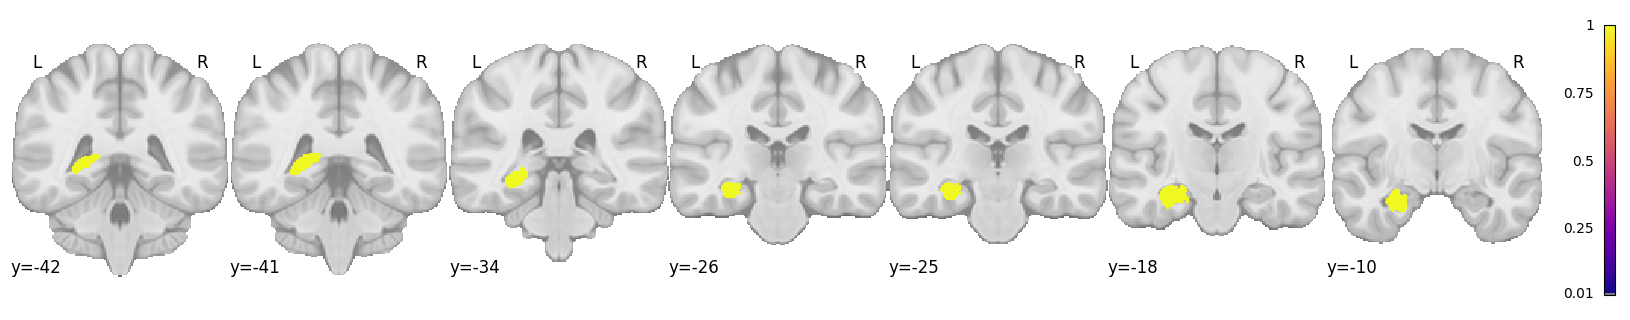

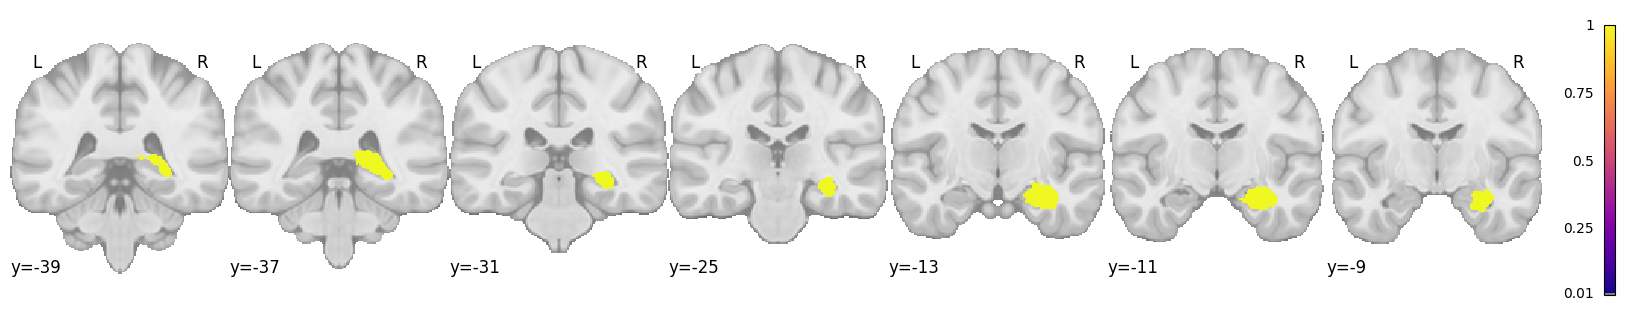

In [17]:
for h in sagittal_segmentation:
  plotting.plot_stat_map(
      nib.Nifti1Image(sagittal_segmentation[h].astype(np.uint8), affine),
      bg_img=mni_img,
      display_mode="y",
      draw_cross=False,
      threshold=0.01,
      black_bg=False,
      colorbar=True,
      cmap="plasma",
      vmin=0,
      vmax=1
  )
plotting.show()

## Segment into anterior and posterior

In [18]:
# Convert y = -18 and y = -24 MNI coordinates to voxel indices
mni_y = [-16, -26]  # new anterior/posterior boundaries
affine = julich_img.affine
inv_affine = np.linalg.inv(affine)  # transform MNI coordinates into matrix indices

# Compute voxel indices for both y values
_, y_index_anterior, _ = np.round(inv_affine @ np.array([0, mni_y[0], 0, 1])).astype(int)[:3]
_, y_index_posterior, _ = np.round(inv_affine @ np.array([0, mni_y[1], 0, 1])).astype(int)[:3]

# Fill masks: segment each hemisphere mask into anterior/posterior parts
masks = {
    h: segmentHippocampusY(seg, y_index_anterior, y_index_posterior)
    for h, seg in sagittal_segmentation.items()
}

# Convert each resulting ROI to a NIfTI image
masks_img = {
    h: {
        roi: nib.Nifti1Image(arr.astype(np.uint8), affine)
        for roi, arr in rois.items()
    }
    for h, rois in masks.items()
}

In [19]:
# ---------------------------------------------------------------------
# Segment each hemisphere mask (left/right) into posterior, middle, anterior according to the Pickatlas coordinates (Valerio)
# ---------------------------------------------------------------------

# Define MNI y-boundaries
# posterior: −40 to −30
# middle: −29 to −19
# anterior: −18 to −4
#mni_y = [-40, -30, -19, -4]

#affine = julich_img.affine
#inv_affine = np.linalg.inv(affine)

# Convert MNI y-values into voxel indices
#y_indices = []
#for y in mni_y:
    #_, y_idx, _ = np.round(inv_affine @ np.array([0, y, 0, 1])).astype(int)[:3]
    #y_indices.append(y_idx)

# Unpack voxel indices
#y_post_start, y_post_end, y_mid_end, y_ant_end = y_indices

# Segment each hemisphere along the y-axis into posterior, middle, and anterior
#masks = {
    #h: segmentHippocampusY(seg, y_post_end, y_mid_end, y_ant_end)
    #for h, seg in sagittal_segmentation.items()
#}

# Convert each resulting ROI to NIfTI images
#masks_img = {
    #h: {
        #roi: nib.Nifti1Image(arr.astype(np.uint8), affine)
        #for roi, arr in rois.items()
    #}
    #for h, rois in masks.items()
#}

#print("✅ Segmented hippocampus into left/right and posterior/middle/anterior subregions.")

In [20]:
#from nilearn import plotting
#import numpy as np

# Example: overlay left hemisphere masks with different colors
#plotting.plot_roi(masks_img['left']['posterior'], bg_img=mni_img, title='Left Hippocampus - Posterior', colorbar=False)
#plotting.plot_roi(masks_img['left']['middle'], bg_img=mni_img, title='Left Hippocampus - Middle', colorbar=False)
#plotting.plot_roi(masks_img['left']['anterior'], bg_img=mni_img, title='Left Hippocampus - Anterior', colorbar=False)
#plotting.show()

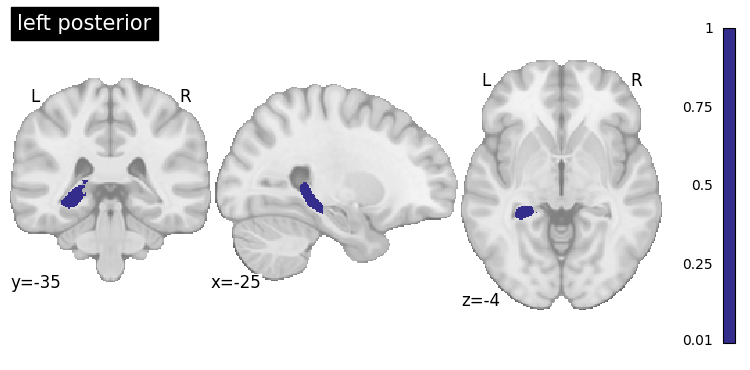

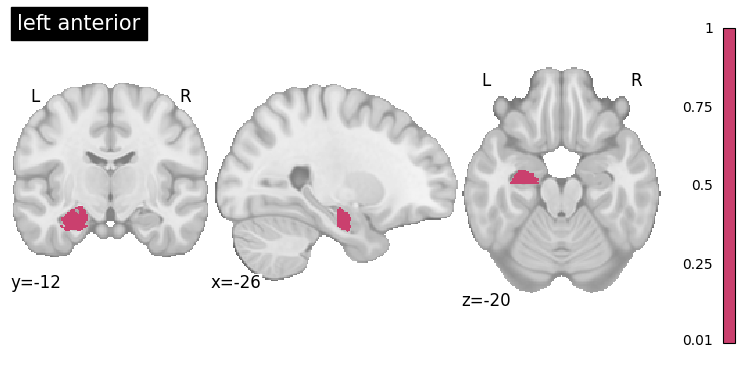

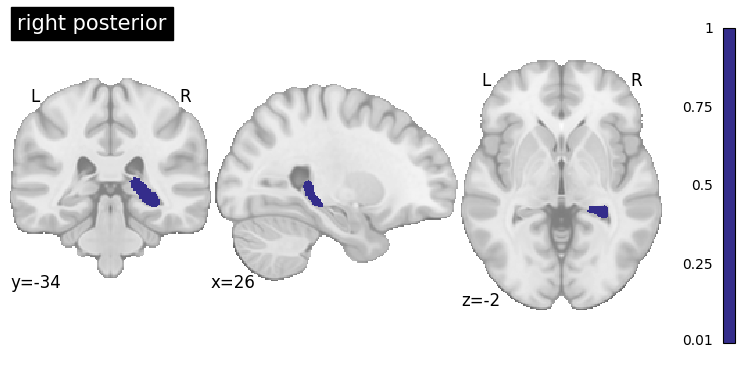

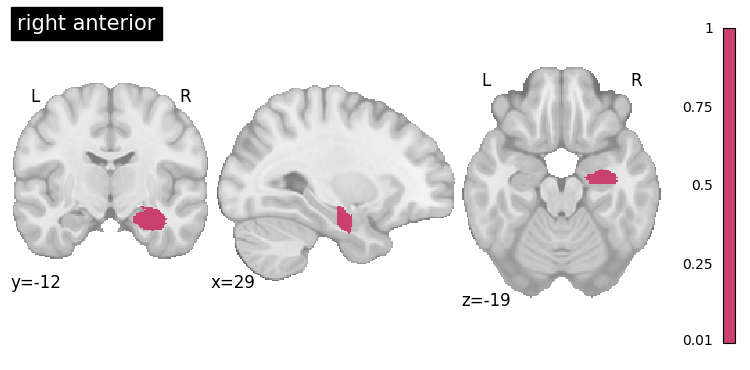

In [21]:
# Check: visualize the longitudinal axis segmentation
colors = {"posterior": '#342d8bff',
          "anterior": '#ca406eff'}
for h in masks_img:
  for roi in masks_img[h]:
    plotting.plot_stat_map(
        masks_img[h][roi],
        bg_img=mni_img,
        draw_cross=False,
        threshold=0.01,
        black_bg=False,
        colorbar=True,
        cmap=mcolors.ListedColormap([[0, 0, 0, 0], colors[roi]]),
        vmin=0,
        vmax=1,
        title=h + " " + roi
    )
  plotting.show()

# Load beta maps

In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [23]:
# A-L's new version

import os
import numpy as np
import nibabel as nib

# Parameters
items = [2, 4, 6, 7, 8, 9, 10]
nItems = len(items)
nParticipants = 23
participants = np.arange(1, nParticipants + 1)

main_folder = "/content/drive/MyDrive/betas_allpatch/" #change to betas_nopatch
print(f"Loading mean beta maps from: {main_folder}")

# Load all mean beta maps
all_imgs = []  # nested list: [participant][item] = Nifti image

for subj_id in participants:
    subj_str = f"subject_{subj_id:02d}"
    subj_dir = os.path.join(main_folder, subj_str, "mean_betas") #change to mean_betas_np or to mean_betas or to concat_betas

    if not os.path.exists(subj_dir):
        print(f"Missing folder for {subj_str}, skipping.")
        continue

    subj_imgs = []
    for item in items:
        beta_filename = f"sub-{subj_id:02d}_object_{item}_mean_beta.nii.gz" #change to _mean_beta_np.nii.gz (or to f"sub-{subj_id:02d}_object_{item}_mean_beta.nii.gz" or f"sub-{subj_id:02d}_concat_object_{item}_beta.nii.gz")
        beta_path = os.path.join(subj_dir, beta_filename)

        if os.path.exists(beta_path):
            subj_imgs.append(nib.load(beta_path))
        else:
            print(f"Missing beta: {beta_filename}")
            subj_imgs = []  # Clear list if incomplete
            break  # skip participant if missing data

    if subj_imgs and len(subj_imgs) == nItems:
        all_imgs.append(subj_imgs)
        print(f"Loaded {len(subj_imgs)} betas for {subj_str}")
    else:
        print(f"Skipping {subj_str} (incomplete data)")

print(f"\nSuccessfully loaded mean betas for {len(all_imgs)} participants.")

Loading mean beta maps from: /content/drive/MyDrive/betas_allpatch/
Loaded 7 betas for subject_01
Loaded 7 betas for subject_02
Loaded 7 betas for subject_03
Loaded 7 betas for subject_04
Loaded 7 betas for subject_05
Loaded 7 betas for subject_06
Loaded 7 betas for subject_07
Loaded 7 betas for subject_08
Loaded 7 betas for subject_09
Loaded 7 betas for subject_10
Loaded 7 betas for subject_11
Loaded 7 betas for subject_12
Loaded 7 betas for subject_13
Loaded 7 betas for subject_14
Loaded 7 betas for subject_15
Loaded 7 betas for subject_16
Loaded 7 betas for subject_17
Loaded 7 betas for subject_18
Loaded 7 betas for subject_19
Loaded 7 betas for subject_20
Loaded 7 betas for subject_21
Loaded 7 betas for subject_22
Loaded 7 betas for subject_23

Successfully loaded mean betas for 23 participants.


# Extract betas for ROIs

In [24]:
# Slice the beta maps
# extractBetas extract the betas for the defined ROI
# Note: voxels is a list of nParticipants elements.
# Each element is a dictionary mirroring the structure of "mask_img", i.e.
# two keys (left and right), whose values have respectively two keys themselves
# (posterior and anterior).
# The voxels[p][hemisphere][posterior] is then the matrix of ROI responses to
# each of the seven items.

voxels = [
    {
        h: {
            roi: [extractBetas(item, masks_img[h][roi]) for item in subj]
            for roi in masks_img[h]
        }
        for h in masks_img
    }
    for subj in all_imgs
]

/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)
/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)
/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. 

In [25]:
# Ignore! Old, neural dissimilarity

#neural_DSMs = [
    #{
        #h: {
            #roi: squareform(pdist(np.asarray(subj[h][roi]), metric=metric))
            #for roi in subj[h]
        #}
        #for h in subj
    #}
    #for subj in voxels
#]

In [40]:
def fisher_z_clip(r, eps=1e-6, clipping=True):
    """
    Apply Fisher z-transform safely by clipping correlations
    to avoid ±1 -> ±inf issues.
    """
    if clipping:
      r = np.clip(r, -1 + eps, 1 - eps)  # clip to [-0.999999, +0.999999]
    z = np.arctanh(r)
    return z

In [27]:
# Important! At a later step, the neural SIMILARITY matrices are Fisher transformed!

neural_NSMs = [  # Renamed variable from neural_DSMs to neural_NSMs
    {
        h: {
            # Change: Replace squareform(pdist(..., metric=metric)) with np.corrcoef(...)
            # np.asarray(subj[h][roi]) is a list of 7 arrays (one per object).
            # To correlate object patterns, we need the 7xN_voxels matrix.
            # np.corrcoef calculates the correlation between ROWS by default.
            # The input is already a list of 7 (object) arrays, so it will correctly
            # calculate the 7x7 correlation matrix between the object patterns.
            roi: np.corrcoef(np.asarray(subj[h][roi]))
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in voxels
]

In [56]:
# Ensure this step is run AFTER the cell that creates 'neural_NSMs'

neural_ZNSMs = [
    {
        h: {
            roi: fisher_z_clip(subj[h][roi], clipping=False)  # <---- uses your clipping function
            for roi in subj[h].keys() # Iterate over the ROI keys within the hemisphere
        }
        for h in subj.keys() # Iterate over the hemisphere keys
    }
    for subj in neural_NSMs
]

/tmp/ipython-input-1346390980.py:8: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)


In [62]:
for p in range(len(neural_ZNSMs)):
  example = neural_ZNSMs[p]['right']['anterior'][~np.eye(7, dtype=bool)]
  print('Participant: ', p)
  print("Shape:", example.shape)
  print("Min:", np.min(example))
  print("Max:", np.max(example))
  print("Mean:", np.mean(example))

Participant:  0
Shape: (42,)
Min: -0.7720885087247645
Max: 0.9571723225800927
Mean: 0.1872332187339085
Participant:  1
Shape: (42,)
Min: -0.5296118342732592
Max: 0.824297112352633
Mean: 0.11755546713595859
Participant:  2
Shape: (42,)
Min: -0.506784633678405
Max: 0.9436320618032368
Mean: 0.40378697810982445
Participant:  3
Shape: (42,)
Min: -1.296473648722632
Max: 0.6583890406942352
Mean: -0.0296418966892401
Participant:  4
Shape: (42,)
Min: -0.39046124027393053
Max: 0.8143794637878381
Mean: 0.2898132952012587
Participant:  5
Shape: (42,)
Min: -0.22340158165400995
Max: 1.0193276175202575
Mean: 0.39168998441947195
Participant:  6
Shape: (42,)
Min: -0.5683204891108544
Max: 1.0540393520861513
Mean: 0.19092526938630316
Participant:  7
Shape: (42,)
Min: -0.34117689688811353
Max: 1.1416354006550082
Mean: 0.3400377118324734
Participant:  8
Shape: (42,)
Min: 0.019652894832417434
Max: 1.2894134080925366
Mean: 0.5766022579725469
Participant:  9
Shape: (42,)
Min: -0.20289169326707088
Max: 1.16023

In [58]:
tensor = np.asarray([[[n[hemisphere][roi][~np.eye(7, dtype=bool)] for roi in ['posterior', 'anterior']] for hemisphere in ['left', 'right']] for n in neural_ZNSMs])
tensor.shape

(23, 2, 2, 42)

In [67]:
np.exp(100)

np.float64(2.6881171418161356e+43)

Important! Here, this is the minimum value across all participants in the neural similarity matrices. Importantly, initially, the neural similarity matrix contained values from -1 to +1 since it plots correlations. But, I Fisher z-transformed them so that the values are now from -infinity to +infinity. In addition, I "ignore" the diagonal since on the diagonal all values are +1 and then transformed to +infinity. Now, the minimum and maximum values that I get for the Fisher z-transformed neural similarity matrices (that also ignore the diagonal) are: -1.30 and +2.19.

In [68]:
np.min(tensor)

np.float64(-1.296473648722632)

In [69]:
np.max(tensor)

np.float64(2.188084552696097)

Important! I asked Valerio why the Fisher z-transformed values are "still" so close to +1 and -1. In other words, why are they not wayy higher? Valerio then told me that the Fisher z-transformation is an asymptote (which makes a lot of sense!!) See the Anna-Lea @HMC Lab slides or Google this link to see what it looks like: https://en.wikipedia.org/wiki/Fisher_transformation#/media/File:Fisher_transformation.svg
